# BirdClef22, Bird classification challenge


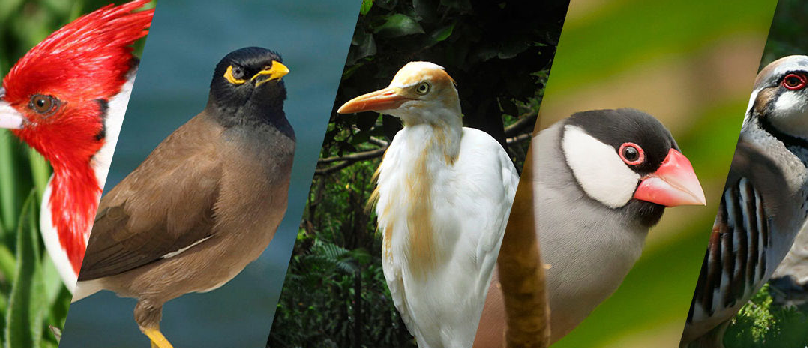

This is the first time I challenge myself in a competition involving sound signals.
The purpose of this notebook is to share my explorations and thoughts about this particular problem, my processings and data explorations.

In [ ]:
!pip install '../input/noisereduce-2-0-0/noisereduce-2.0.0-py3-none-any.whl'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display,Audio
import os
import soundfile as sf
import os
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import glob
import IPython

import random

import json

import plotly.express as px

import noisereduce as nr

import folium

from librosa import cqt

def plotDot(point):
    return folium.CircleMarker(location=[point.latitude, point.longitude],
                        radius=2,
                        weight=5, 
                        color = color_birds[point.primary_label],
                        popup = point.primary_label)
   
def play_arr(arr, rate):
    sf.write(data=arr, file = 'temp.ogg', samplerate=rate)
    display(Audio('temp.ogg', rate=rate))
    
    
def gen_signals(filenames):
    denoised_signals = []
    signals = []
    for p in filenames:
        path = f'/kaggle/input/birdclef-2022/train_audio/{p}'
        ts, sample_rate = sf.read(path)

        if len(ts.shape) == 2:
            ts = ts[:,0]

        k = sample_rate * 5
        L = len(ts)//k
        for j in range(L):
            sub = ts[j*k:(j+1)*k]
            reduced_noise = nr.reduce_noise(y=sub.copy(), sr=sample_rate)
            denoised_signals.append(reduced_noise)
            signals.append(sub)
            
    return np.hstack(signals), np.hstack(denoised_signals)

SAMPLE_RATE = 32000

def viz_all(signals, denoised_signals, t1, t2):

    arr1 = denoised_signals[int(t1*SAMPLE_RATE):int(t2*SAMPLE_RATE)]
    arr2 = signals[int(t1*SAMPLE_RATE):int(t2*SAMPLE_RATE)]
    print("listen original signal: ")
    play_arr(arr2, SAMPLE_RATE)
    print("listen denoised signal: ")
    play_arr(arr1, SAMPLE_RATE)
    arr1_q = abs(cqt(arr1, sr = SAMPLE_RATE, fmin=125, hop_length= int(SAMPLE_RATE*0.006)))
    arr2_q = abs(cqt(arr2, sr = SAMPLE_RATE, fmin=125, hop_length= int(SAMPLE_RATE*0.006)))
    plt.figure(figsize = (30,5))
    plt.title("Temporal signal (noisy and denoised)")
    plt.plot(np.arange(len(arr1))/SAMPLE_RATE, arr2, alpha = 0.5)
    plt.plot(np.arange(len(arr1))/SAMPLE_RATE, arr1)
    plt.show()
    plt.figure(figsize = (30,8))
    plt.subplot(1,2,1)
    plt.title("Frequency signal noisy")
    plt.imshow(arr2_q, vmax = np.quantile(arr2_q, 0.99), cmap='jet')
    plt.subplot(1,2,2)
    plt.title("Frequency signal denoised")
    plt.imshow(arr1_q, vmax = np.quantile(arr1_q, 0.99), cmap='jet')
    plt.show()
    

def gen_random_color():
    random_number = random.randint(0,16777215)
    hex_number = str(hex(random_number))
    hex_number ='#'+ hex_number[2:]
    return hex_number

## Train metadata

The train metadata dataset gives information about the different audios inputs: type of bird singing, geographical location, time, quality of the file, etc...

In [ ]:
df = pd.read_csv('../input/birdclef-2022/train_metadata.csv')
df.tail()

All the birds available in the train set will not be scored. The scored_birds json indicates birds that are actually scored in the final test set. The figure below shows the representation, in term of number of recording, of those scored birds compared to the whole dataset

In [ ]:
with open('../input/birdclef-2022/scored_birds.json', 'r') as f:
    scored_birds = json.load(f)
    
color_birds = {}
for bird in scored_birds:
    color_birds[bird] = gen_random_color()

In [ ]:
count_birds = df.groupby("primary_label")['filename'].count().sort_values(ascending = False)
colors = [1 if e in scored_birds else 0 for e in count_birds.index ]

fig = go.Figure(
    go.Bar(
        x = count_birds.index,
        y = count_birds.values,
        marker = {"color": colors}
    )
)


fig.update_layout(
    title = "Number of samples per bird type",
    template='presentation',
    xaxis = dict(
        tickmode = 'array',
        tickfont = dict(size=10),
        tickvals = np.where(count_birds.index.isin(scored_birds))[0]
    ))

fig.show()

Another information potentially usefull is the location of the recording. The map below shows that some of the species have been particularly recorded in some area of the world. This information could be also usefull for our futur predictions.

In [ ]:
sub = df[df.primary_label.isin(scored_birds)]
m = folium.Map()
for i, point in sub.iterrows():
    plotDot(point).add_to(m)
    
m

The number of sample might not be the most relevant metric, as all records don't have the same time duration.
In order to have a better view of the actual time duration of all records for each birds, I created a extended dataset where I collected this information.

In particular, the time duration of the tested birds is less than 10% of the total recordings available

In [ ]:
df_extanded = pd.read_csv('../input/extanded-data/birdclef-2022_train_extended_metadata.csv', index_col=0)
time_birds = df_extanded.groupby("primary_label")['audio_length'].sum().sort_values(ascending = False)
colors = [1 if e in scored_birds else 0 for e in time_birds.index]

fig = go.Figure(
    go.Bar(
        x = time_birds.index,
        y = time_birds.values/60,
        marker = {"color": colors}
    )
)


fig.update_layout(
    title = "Number of samples per bird type",
    template='presentation',
    xaxis = dict(
        tickmode = 'array',
        tickfont = dict(size=10),
        tickvals = np.where(time_birds.index.isin(scored_birds))[0]
    ))

fig.show()

In [ ]:
pie = time_birds.groupby(colors).sum().reset_index()
fig = px.pie(pie, values = 'audio_length', names = ['Not to test', 'To test'], color_discrete_sequence=['#e3e3e3',"#C70039"])
fig.update_layout(template = 'presentation', width = 600, title = 'Fraction of labels scored in the test set')
fig.show()

## Audio Signals prints, bird by bird

Some of the species have very few recording, so it would be a mistake not to look at them carefully before attempting any type of predictions. 

In this section, I am going to process the signal as follow:
- load arrays bird by bird
- denoise signal by using noisereduce 2.0 (Thanks Zoltán Kucsik sharing!)
- Perform Q-transform
- Isolate, if possible, a recognisable pattern

One of the big challenge of the competition is the small number of recordings for some of the samples, and we should pay very particular attention to isolate correctly the information available if we want to have a chance to predict something accurate.

We see that despites of the small number of sounds available, the signatures look different enough to be well segmented

### Puaioh

In [ ]:
filenames = df[df.primary_label == "puaioh"]['filename']
signals, denoised_signals = gen_signals(filenames)

In [ ]:
band = 0
t1 = band*5 + 0.9
t2 = band*5 + 1.8
viz_all(signals, denoised_signals, t1, t2)

Not sure if this last pattern is also to keep...

In [ ]:
band = 5
t1 = band*5 + 0.5
t2 = band*5 + 1.5
viz_all(signals, denoised_signals, t1, t2)

### Ercfra

In [ ]:
filenames = df[df.primary_label == "ercfra"]['filename']
signals, denoised_signals = gen_signals(filenames)

In [ ]:
band = 0
t1 = band*5 + 1
t2 = band*5 + 3
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 10
t1 = band*5 + 2.5
t2 = band*5 + 3.2
viz_all(signals, denoised_signals, t1, t2)

### Crehon

In [ ]:
filenames = df[df.primary_label == "crehon"]['filename']
signals, denoised_signals = gen_signals(filenames)

In [ ]:
band = 0
t1 = band*5 + 3.5
t2 = band*5 + 4.6
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 2
t1 = band*5 + 3.3
t2 = band*5 + 4.3
viz_all(signals, denoised_signals, t1, t2)

### Hawpet1

In [ ]:
filenames = df[df.primary_label == "hawpet1"]['filename']
signals, denoised_signals = gen_signals(filenames)

In [ ]:
band = 16
t1 = band*5 + 0
t2 = band*5 + 1
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 16
t1 = band*5 + 2
t2 = band*5 + 4
viz_all(signals, denoised_signals, t1, t2)

This one seems in the same tones, so I leave it for now...

In [ ]:
band = 11
t1 = band*5 + 3
t2 = band*5 + 5
viz_all(signals, denoised_signals, t1, t2)

### Hawhaw

In [ ]:
filenames = df[df.primary_label == "hawhaw"]['filename']
signals, denoised_signals = gen_signals(filenames)

In [ ]:
band = 0
t1 = band*5 + 2
t2 = band*5 + 3
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 17
t1 = band*5 + 2
t2 = band*5 + 3
viz_all(signals, denoised_signals, t1, t2)

### Ercfra



In [ ]:
filenames = df[df.primary_label == "ercfra"]['filename']
signals, denoised_signals = gen_signals(filenames)

In [ ]:
band = 0
t1 = band*5 + 2
t2 = band*5 + 2.5
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 6
t1 = band*5 + 3.4
t2 = band*5 + 5
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 8
t1 = band*5 + 2.3
t2 = band*5 + 4.3
viz_all(signals, denoised_signals, t1, t2)

### Hawgoo

In [ ]:
filenames = df[df.primary_label == "hawgoo"]['filename']
signals, denoised_signals = gen_signals(filenames)

In [ ]:
band = 1
t1 = band*5 + 2.5
t2 = band*5 + 3
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 6
t1 = band*5 + 1
t2 = band*5 + 1.5
viz_all(signals, denoised_signals, t1, t2)

### Aniani

In [ ]:
filenames = df[df.primary_label == "aniani"].iloc[3:7]['filename']
signals, denoised_signals = gen_signals(filenames)

In [ ]:
band = 0
t1 = band*5 + 2.3
t2 = band*5 + 3
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 6
t1 = band*5 + 1.8
t2 = band*5 + 3
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 8
t1 = band*5 + 1.5
t2 = band*5 + 2.5
viz_all(signals, denoised_signals, t1, t2)

### Elepai

In [ ]:
filenames = df[df.primary_label == "elepai"]['filename']
signals, denoised_signals = gen_signals(filenames)

In [ ]:
band = 5
t1 = band*5 + 1.5
t2 = band*5 + 2.8
viz_all(signals, denoised_signals, t1, t2)

In [ ]:
band = 15
t1 = band*5 + 3.5
t2 = band*5 + 5
viz_all(signals, denoised_signals, t1, t2)

Thanks for reading !

## Next steps

Adding more birds sound signature...